In [4]:
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np
from torchvision.transforms import transforms
import os
import requests
import tarfile
import shutil

IMAGENETTE_CLASSES = {
    'tench': 'n01440764',
    'English springer': 'n02102040',
    'cassette player': 'n02979186',
    'chain saw': 'n03000684',
    'church': 'n03028079',
    'French horn': 'n03394916',
    'garbage truck': 'n03417042',
    'gas pump': 'n03425413',
    'golf ball': 'n03445777',
    'parachute': 'n03888257'
}

CLASSES_TO_IDX = {
    'tench': 0,
    'English springer': 1,
    'cassette player': 2,
    'chain saw': 3,
    'church': 4,
    'French horn': 5,
    'garbage truck': 6,
    'gas pump': 7,
    'golf ball': 8,
    'parachute': 9
}


class Imagenette(Dataset):

    def __init__(self, path: str, train: bool):
        self.path = path
        self.train = train
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

        if train:
            self.path += '/train'
        else:
            self.path += '/val'

        self.images = []
        self.labels = []

        for label, folder in IMAGENETTE_CLASSES.items():
            label_idx = CLASSES_TO_IDX[label]
            for image in os.listdir(f'{self.path}/{folder}'):
                self.images.append(f'{self.path}/{folder}/{image}')
                self.labels.append(label_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # Load image with PIL
        image = Image.open(self.images[index]).convert('RGB')
        tensor = self.transform(image)
        image.close()
        return tensor, self.labels[index]




if __name__ == '__main__':
    if not (os.path.exists("imagenette2")):
      url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
      target_path = 'imagenette2.tar.gz'

      response = requests.get(url, stream=True)
      if response.status_code == 200:
          with open(target_path, 'wb') as f:
              f.write(response.raw.read())

      shutil.rmtree('imagenette2-160', ignore_errors=True)
      tar = tarfile.open(target_path, "r:gz")
      tar.extractall()
      tar.close()

      os.rename("imagenette2-160","imagenette2")
    
    dataset_train = Imagenette('imagenette2', train=True)
    dataset_val = Imagenette('imagenette2', train=False)

    print(len(dataset_train))
    print(dataset_train[0][0].shape, dataset_train[0][1])

    print(len(dataset_val))
    print(dataset_val[0][0].shape, dataset_val[0][1])

9469
torch.Size([3, 64, 64]) 0
3925
torch.Size([3, 64, 64]) 0


In [5]:
#With everything

# Note: The one change we need to make if we're in Colab is to uncomment this below block.
# If we are in an ipython session or a notebook, clear the state to avoid bugs
"""
try:
  _ = get_ipython().__class__.__name__
  ## we set -f below to avoid prompting the user before clearing the notebook state
  %reset -f
except NameError:
  pass ## we're still good
"""
import functools
from functools import partial
import os
import copy

import torch
import torch.nn.functional as F
from torch import nn

import torchvision
from torchvision import transforms

## <-- teaching comments
# <-- functional comments
# You can run 'sed -i.bak '/\#\#/d' ./main.py' to remove the teaching comments if they are in the way of your work. <3

# This can go either way in terms of actually being helpful when it comes to execution speed.
#torch.backends.cudnn.benchmark = True

# This code was built from the ground up to be directly hackable and to support rapid experimentation, which is something you might see
# reflected in what would otherwise seem to be odd design decisions. It also means that maybe some cleaning up is required before moving
# to production if you're going to use this code as such (such as breaking different section into unique files, etc). That said, if there's
# ways this code could be improved and cleaned up, please do open a PR on the GitHub repo. Your support and help is much appreciated for this
# project! :)


# This is for testing that certain changes don't exceed some X% portion of the reference GPU (here an A100)
# so we can help reduce a possibility that future releases don't take away the accessibility of this codebase.
#torch.cuda.set_per_process_memory_fraction(fraction=6.5/40., device=0) ## 40. GB is the maximum memory of the base A100 GPU

# set global defaults (in this particular file) for convolutions
default_conv_kwargs = {'kernel_size': 3, 'padding': 'same', 'bias': False}

batchsize = 1024
bias_scaler = 32
# To replicate the ~95.84%-accuracy-in-172-seconds runs, you can change the base_depth from 64->128, num_epochs from 10->90, ['ema'] epochs 9->78, and cutout 0->11
hyp = {
    'opt': {
        'bias_lr':        2.1 * bias_scaler/512, # TODO: How we're expressing this information feels somewhat clunky, is there maybe a better way to do this? :'))))
        'non_bias_lr':    2.1 / 512,
        'bias_decay':     6.45e-4 * batchsize/bias_scaler,
        'non_bias_decay': 6.45e-4 * batchsize,
        'scaling_factor': 1./10,
        'percent_start': .15,
        'loss_scale_scaler': 4., # * Regularizer inside the loss summing (range: ~1/512 - 16+). FP8 should help with this somewhat too, whenever it comes out. :)
    },
    'net': {
        'whitening': {
            'kernel_size': 2,
            'num_examples': 50000,
        },
        'batch_norm_momentum': .8, # Equivalent roughly to updating entirely every step, as momentum for batchnorm is represented in a different way (1 - momentum) due to a quirk of the original paper... ;'((((
        'cutout_size': 0,
        'pad_amount': 2,
        'base_depth': 64 ## This should be a factor of 8 in some way to stay tensor core friendly
    },
    'misc': {
        'ema': {
            'epochs': 9,
            'decay_base': .98,
            'every_n_steps': 5,
        },
        'train_epochs': 25,
        'device': 'cuda',
        'data_location': 'data.pt',
    }
}

#############################################
#                Dataloader                 #
#############################################

if not os.path.exists(hyp['misc']['data_location']):

    # use the dataloader to get a single batch of all of the dataset items at once.
    train_dataset_gpu_loader = torch.utils.data.DataLoader(dataset_train, batch_size=len(dataset_train), drop_last=True,
                                                shuffle=True, num_workers=2, persistent_workers=False)
    eval_dataset_gpu_loader = torch.utils.data.DataLoader(dataset_val, batch_size=len(dataset_val), drop_last=True,
                                                shuffle=False, num_workers=1, persistent_workers=False)

    train_dataset_gpu = {}
    eval_dataset_gpu = {}

    train_dataset_gpu['images'], train_dataset_gpu['targets'] = [item.to(device=hyp['misc']['device'], non_blocking=True) for item in next(iter(train_dataset_gpu_loader))]
    eval_dataset_gpu['images'],  eval_dataset_gpu['targets']  = [item.to(device=hyp['misc']['device'], non_blocking=True) for item in next(iter(eval_dataset_gpu_loader)) ]

    cifar10_std, cifar10_mean = torch.std_mean(train_dataset_gpu['images'], dim=(0, 2, 3)) # dynamically calculate the std and mean from the data. this shortens the code and should help us adapt to new datasets!

    def batch_normalize_images(input_images, mean, std):
        return (input_images - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)

    # preload with our mean and std
    batch_normalize_images = partial(batch_normalize_images, mean=cifar10_mean, std=cifar10_std)

    ## Batch normalize datasets, now. Wowie. We did it! We should take a break and make some tea now.
    train_dataset_gpu['images'] = batch_normalize_images(train_dataset_gpu['images'])
    eval_dataset_gpu['images']  = batch_normalize_images(eval_dataset_gpu['images'])

    data = {
        'train': train_dataset_gpu,
        'eval': eval_dataset_gpu
    }

    ## Convert dataset to FP16 now for the rest of the process....
    data['train']['images'] = data['train']['images'].half()
    data['eval']['images']  = data['eval']['images'].half()

    torch.save(data, hyp['misc']['data_location'])

else:
    ## This is effectively instantaneous, and takes us practically straight to where the dataloader-loaded dataset would be. :)
    ## So as long as you run the above loading process once, and keep the file on the disc it's specified by default in the above
    ## hyp dictionary, then we should be good. :)
    data = torch.load(hyp['misc']['data_location'])


## As you'll note above and below, one difference is that we don't count loading the raw data to GPU since it's such a variable operation, and can sort of get in the way
## of measuring other things. That said, measuring the preprocessing (outside of the padding) is still important to us.

# Pad the GPU training dataset
if hyp['net']['pad_amount'] > 0:
    ## Uncomfortable shorthand, but basically we pad evenly on all _4_ sides with the pad_amount specified in the original dictionary
    data['train']['images'] = F.pad(data['train']['images'], (hyp['net']['pad_amount'],)*4, 'reflect')

#############################################
#            Network Components             #
#############################################

# We might be able to fuse this weight and save some memory/runtime/etc, since the fast version of the network might be able to do without somehow....
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-12, momentum=hyp['net']['batch_norm_momentum'], weight=False, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

# Allows us to set default arguments for the whole convolution itself.
class Conv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        kwargs = {**default_conv_kwargs, **kwargs}
        super().__init__(*args, **kwargs)
        self.kwargs = kwargs

# can hack any changes to each residual group that you want directly in here
class ConvGroup(nn.Module):
    def __init__(self, channels_in, channels_out, pool):
        super().__init__()
        self.pool = pool # todo: maybe we can condense this later

        self.channels_in = channels_in
        self.channels_out = channels_out

        self.pool1 = nn.MaxPool2d(2)
        self.conv1 = Conv(channels_in, channels_out)
        self.conv2 = Conv(channels_out, channels_out)
        self.norm1 = BatchNorm(channels_out)
        self.norm2 = BatchNorm(channels_out)
        self.activ = nn.GELU()


    def forward(self, x):
        x = self.conv1(x)
        if self.pool:
            x = self.pool1(x)
        x = self.norm1(x)
        x = self.activ(x)
        residual = x
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.activ(x)
        x = x + residual # haiku

        return x

class TemperatureScaler(nn.Module):
    def __init__(self, init_val):
        super().__init__()
        self.scaler = torch.tensor(init_val)

    def forward(self, x):
        x.float() ## save precision for the gradients in the backwards pass
                  ## I personally believe from experience that this is important
                  ## for a few reasons. I believe this is the main functional difference between
                  ## my implementation, and David's implementation...
        return x.mul(self.scaler)

class FastGlobalMaxPooling(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        # Previously was chained torch.max calls.
        # requires less time than AdaptiveMax2dPooling -- about ~.3s for the entire run, in fact (which is pretty significant! :O :D :O :O <3 <3 <3 <3)
        return torch.amax(x, dim=(2,3)) # Global maximum pooling

#############################################
#          Init Helper Functions            #
#############################################

def get_patches(x, patch_shape=(3, 3), dtype=torch.float32):
    # This uses the unfold operation (https://pytorch.org/docs/stable/generated/torch.nn.functional.unfold.html?highlight=unfold#torch.nn.functional.unfold)
    # to extract a _view_ (i.e., there's no data copied here) of blocks in the input tensor. We have to do it twice -- once horizontally, once vertically. Then
    # from that, we get our kernel_size*kernel_size patches to later calculate the statistics for the whitening tensor on :D
    c, (h, w) = x.shape[1], patch_shape
    return x.unfold(2,h,1).unfold(3,w,1).transpose(1,3).reshape(-1,c,h,w).to(dtype) # TODO: Annotate?

def get_whitening_parameters(patches):
    # As a high-level summary, we're basically finding the high-dimensional oval that best fits the data here.
    # We can then later use this information to map the input information to a nicely distributed sphere, where also
    # the most significant features of the inputs each have their own axis. This significantly cleans things up for the
    # rest of the neural network and speeds up training.
    n,c,h,w = patches.shape
    est_covariance = torch.cov(patches.view(n, c*h*w).t())
    eigenvalues, eigenvectors = torch.linalg.eigh(est_covariance, UPLO='U') # this is the same as saying we want our eigenvectors, with the specification that the matrix be an upper triangular matrix (instead of a lower-triangular matrix)
    return eigenvalues.flip(0).view(-1, 1, 1, 1), eigenvectors.t().reshape(c*h*w,c,h,w).flip(0)

# Run this over the training set to calculate the patch statistics, then set the initial convolution as a non-learnable 'whitening' layer
def init_whitening_conv(layer, train_set=None, num_examples=None, previous_block_data=None, pad_amount=None, freeze=True, whiten_splits=None):
    if train_set is not None and previous_block_data is None:
        if pad_amount > 0:
            previous_block_data = train_set[:num_examples,:,pad_amount:-pad_amount,pad_amount:-pad_amount] # if it's none, we're at the beginning of our network.
        else:
            previous_block_data = train_set[:num_examples,:,:,:]

    # chunking code to save memory for smaller-memory-size (generally consumer) GPUs
    if whiten_splits is None:
         previous_block_data_split = [previous_block_data] # If we're whitening in one go, then put it in a list for simplicity to reuse the logic below
    else:
         previous_block_data_split = previous_block_data.split(whiten_splits, dim=0) # Otherwise, we split this into different chunks to keep things manageable

    eigenvalue_list, eigenvector_list = [], []
    for data_split in previous_block_data_split:
        eigenvalues, eigenvectors = get_whitening_parameters(get_patches(data_split, patch_shape=layer.weight.data.shape[2:]))
        eigenvalue_list.append(eigenvalues)
        eigenvector_list.append(eigenvectors)

    eigenvalues = torch.stack(eigenvalue_list, dim=0).mean(0)
    eigenvectors = torch.stack(eigenvector_list, dim=0).mean(0)
    # i believe the eigenvalues and eigenvectors come out in float32 for this because we implicitly cast it to float32 in the patches function (for numerical stability)
    set_whitening_conv(layer, eigenvalues.to(dtype=layer.weight.dtype), eigenvectors.to(dtype=layer.weight.dtype), freeze=freeze)
    data = layer(previous_block_data.to(dtype=layer.weight.dtype))
    return data

def set_whitening_conv(conv_layer, eigenvalues, eigenvectors, eps=1e-2, freeze=True):
    shape = conv_layer.weight.data.shape
    conv_layer.weight.data[-eigenvectors.shape[0]:, :, :, :] = (eigenvectors/torch.sqrt(eigenvalues+eps))[-shape[0]:, :, :, :] # set the first n filters of the weight data to the top n significant (sorted by importance) filters from the eigenvectors
    ## We don't want to train this, since this is implicitly whitening over the whole dataset
    ## For more info, see David Page's original blogposts (link in the README.md as of this commit.)
    if freeze: 
        conv_layer.weight.requires_grad = False


#############################################
#            Network Definition             #
#############################################

scaler = 2. ## You can play with this on your own if you want, for the first beta I wanted to keep things simple (for now) and leave it out of the hyperparams dict
depths = {
    'init':   round(scaler**-1*hyp['net']['base_depth']), # 32  w/ scaler at base value
    'block1': round(scaler** 1*hyp['net']['base_depth']), # 128 w/ scaler at base value
    'block2': round(scaler** 2*hyp['net']['base_depth']), # 256 w/ scaler at base value
    'block3': round(scaler** 3*hyp['net']['base_depth']), # 512 w/ scaler at base value
    'num_classes': 10
}

class SpeedyResNet(nn.Module):
    def __init__(self, network_dict):
        super().__init__()
        self.net_dict = network_dict # flexible, defined in the make_net function

    # This allows you to customize/change the execution order of the network as needed.
    def forward(self, x):
        if not self.training:
            x = torch.cat((x, torch.flip(x, (-1,))))
        x = self.net_dict['initial_block']['whiten'](x)
        x = self.net_dict['initial_block']['project'](x)
        x = self.net_dict['initial_block']['norm'](x)
        x = self.net_dict['initial_block']['activation'](x)
        x = self.net_dict['residual1'](x)
        x = self.net_dict['residual2'](x)
        x = self.net_dict['residual3'](x)
        x = self.net_dict['pooling'](x)
        x = self.net_dict['linear'](x)
        x = self.net_dict['temperature'](x)
        if not self.training:
            # Average the predictions from the lr-flipped inputs during eval
            orig, flipped = x.split(x.shape[0]//2, dim=0)
            x = .5 * orig + .5 * flipped
        return x

def make_net():
    # TODO: A way to make this cleaner??
    # Note, you have to specify any arguments overlapping with defaults (i.e. everything but in/out depths) as kwargs so that they are properly overridden (TODO cleanup somehow?)
    whiten_conv_depth = 3*hyp['net']['whitening']['kernel_size']**2
    network_dict = nn.ModuleDict({
        'initial_block': nn.ModuleDict({
            'whiten': Conv(3, whiten_conv_depth, kernel_size=hyp['net']['whitening']['kernel_size'], padding=0),
            'project': Conv(whiten_conv_depth, depths['init'], kernel_size=1),
            'norm': BatchNorm(depths['init'], weight=False),
            'activation': nn.GELU(),
        }),
        'residual1': ConvGroup(depths['init'],   depths['block1'], pool=True),
        'residual2': ConvGroup(depths['block1'], depths['block2'], pool=True),
        'residual3': ConvGroup(depths['block2'], depths['block3'], pool=True),
        'pooling': FastGlobalMaxPooling(),
        'linear': nn.Linear(depths['block3'], depths['num_classes'], bias=False),
        'temperature': TemperatureScaler(hyp['opt']['scaling_factor'])
    })

    net = SpeedyResNet(network_dict)
    net = net.to(hyp['misc']['device'])
    net = net.to(memory_format=torch.channels_last) # to appropriately use tensor cores/avoid thrash while training
    net.train()
    net.half() # Convert network to half before initializing the initial whitening layer.

    ## Initialize the whitening convolution
    with torch.no_grad():
        # Initialize the first layer to be fixed weights that whiten the expected input values of the network be on the unit hypersphere. (i.e. their...average vector length is 1.?, IIRC)
        init_whitening_conv(net.net_dict['initial_block']['whiten'],
                            data['train']['images'].index_select(0, torch.randperm(data['train']['images'].shape[0], device=data['train']['images'].device)),
                            num_examples=hyp['net']['whitening']['num_examples'],
                            pad_amount=hyp['net']['pad_amount'],
                            whiten_splits=5000) ## Hardcoded for now while we figure out the optimal whitening number
                                                ## If you're running out of memory (OOM) feel free to decrease this, but
                                                ## the index lookup in the dataloader may give you some trouble depending
                                                ## upon exactly how memory-limited you are

    return net

#############################################
#            Data Preprocessing             #
#############################################

## This is actually (I believe) a pretty clean implementation of how to do something like this, since shifted-square masks unique to each depth-channel can actually be rather
## tricky in practice. That said, if there's a better way, please do feel free to submit it! This can be one of the harder parts of the code to understand (though I personally get
## stuck on the fold/unfold process for the lower-level convolution calculations.
def make_random_square_masks(inputs, mask_size):
    ##### TODO: Double check that this properly covers the whole range of values. :'( :')
    if mask_size == 0:
        return None # no need to cutout or do anything like that since the patch_size is set to 0
    is_even = int(mask_size % 2 == 0)
    in_shape = inputs.shape

    # seed centers of squares to cutout boxes from, in one dimension each
    mask_center_y = torch.empty(in_shape[0], dtype=torch.long, device=inputs.device).random_(mask_size//2-is_even, in_shape[-2]-mask_size//2-is_even)
    mask_center_x = torch.empty(in_shape[0], dtype=torch.long, device=inputs.device).random_(mask_size//2-is_even, in_shape[-1]-mask_size//2-is_even)

    # measure distance, using the center as a reference point
    to_mask_y_dists = torch.arange(in_shape[-2], device=inputs.device).view(1, 1, in_shape[-2], 1) - mask_center_y.view(-1, 1, 1, 1)
    to_mask_x_dists = torch.arange(in_shape[-1], device=inputs.device).view(1, 1, 1, in_shape[-1]) - mask_center_x.view(-1, 1, 1, 1)

    to_mask_y = (to_mask_y_dists >= (-(mask_size // 2) + is_even)) * (to_mask_y_dists <= mask_size // 2)
    to_mask_x = (to_mask_x_dists >= (-(mask_size // 2) + is_even)) * (to_mask_x_dists <= mask_size // 2)

    final_mask = to_mask_y * to_mask_x ## Turn (y by 1) and (x by 1) boolean masks into (y by x) masks through multiplication. Their intersection is square, hurray! :D

    return final_mask

def batch_cutout(inputs, patch_size):
    with torch.no_grad():
        cutout_batch_mask = make_random_square_masks(inputs, patch_size)
        if cutout_batch_mask is None:
            return inputs # if the mask is None, then that's because the patch size was set to 0 and we will not be using cutout today.
        # TODO: Could be fused with the crop operation for sheer speeeeeds. :D <3 :))))
        cutout_batch = torch.where(cutout_batch_mask, torch.zeros_like(inputs), inputs)
        return cutout_batch

def batch_crop(inputs, crop_size):
    with torch.no_grad():
        crop_mask_batch = make_random_square_masks(inputs, crop_size)
        cropped_batch = torch.masked_select(inputs, crop_mask_batch).view(inputs.shape[0], inputs.shape[1], crop_size, crop_size)
        return cropped_batch

def batch_flip_lr(batch_images, flip_chance=.5):
    with torch.no_grad():
        # TODO: Is there a more elegant way to do this? :') :'((((
        return torch.where(torch.rand_like(batch_images[:, 0, 0, 0].view(-1, 1, 1, 1)) < flip_chance, torch.flip(batch_images, (-1,)), batch_images)


########################################
#          Training Helpers            #
########################################

class NetworkEMA(nn.Module):
    def __init__(self, net, decay):
        super().__init__() # init the parent module so this module is registered properly
        self.net_ema = copy.deepcopy(net).eval().requires_grad_(False) # copy the model
        self.decay = decay ## you can update/hack this as necessary for update scheduling purposes :3

    def update(self, current_net):
        with torch.no_grad():
            for ema_net_parameter, (parameter_name, incoming_net_parameter) in zip(self.net_ema.state_dict().values(), current_net.state_dict().items()): # potential bug: assumes that the network architectures don't change during training (!!!!)
                if incoming_net_parameter.dtype in (torch.half, torch.float):
                    ema_net_parameter.mul_(self.decay).add_(incoming_net_parameter.detach().mul(1. - self.decay)) # update the ema values in place, similar to how optimizer momentum is coded
                    if not 'running' in parameter_name:
                        incoming_net_parameter = ema_net_parameter.detach()

    def forward(self, inputs):
        with torch.no_grad():
            return self.net_ema(inputs)

# TODO: Could we jit this in the (more distant) future? :)
@torch.no_grad()
def get_batches(data_dict, key, batchsize):
    num_epoch_examples = len(data_dict[key]['images'])
    shuffled = torch.randperm(num_epoch_examples, device='cuda')
    crop_size = 32
    ## Here, we prep the dataset by applying all data augmentations in batches ahead of time before each epoch, then we return an iterator below
    ## that iterates in chunks over with a random derangement (i.e. shuffled indices) of the individual examples. So we get perfectly-shuffled
    ## batches (which skip the last batch if it's not a full batch), but everything seems to be (and hopefully is! :D) properly shuffled. :)
    if key == 'train':
        images = batch_crop(data_dict[key]['images'], crop_size) # TODO: hardcoded image size for now?
        images = batch_flip_lr(images)
        images = batch_cutout(images, patch_size=hyp['net']['cutout_size'])
    else:
        images = data_dict[key]['images']

    # Send the images to an (in beta) channels_last to help improve tensor core occupancy (and reduce NCHW <-> NHWC thrash) during training
    images = images.to(memory_format=torch.channels_last)
    for idx in range(num_epoch_examples // batchsize):
        if not (idx+1)*batchsize > num_epoch_examples: ## Use the shuffled randperm to assemble individual items into a minibatch
            yield images.index_select(0, shuffled[idx*batchsize:(idx+1)*batchsize]), \
                  data_dict[key]['targets'].index_select(0, shuffled[idx*batchsize:(idx+1)*batchsize]) ## Each item is only used/accessed by the network once per epoch. :D


def init_split_parameter_dictionaries(network):
    params_non_bias = {'params': [], 'lr': hyp['opt']['non_bias_lr'], 'momentum': .85, 'nesterov': True, 'weight_decay': hyp['opt']['non_bias_decay']}
    params_bias     = {'params': [], 'lr': hyp['opt']['bias_lr'],     'momentum': .85, 'nesterov': True, 'weight_decay': hyp['opt']['bias_decay']}

    for name, p in network.named_parameters():
        if p.requires_grad:
            if 'bias' in name:
                params_bias['params'].append(p)
            else:
                params_non_bias['params'].append(p)
    return params_non_bias, params_bias


## Hey look, it's the soft-targets/label-smoothed loss! Native to PyTorch. Now, _that_ is pretty cool, and simplifies things a lot, to boot! :D :)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.2, reduction='none')

logging_columns_list = ['epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc', 'ema_val_acc', 'total_time_seconds']
# define the printing function and print the column heads
def print_training_details(columns_list, separator_left='|  ', separator_right='  ', final="|", column_heads_only=False, is_final_entry=False):
    print_string = ""
    if column_heads_only:
        for column_head_name in columns_list:
            print_string += separator_left + column_head_name + separator_right
        print_string += final
        print('-'*(len(print_string))) # print the top bar
        print(print_string)
        print('-'*(len(print_string))) # print the bottom bar
    else:
        for column_value in columns_list:
            print_string += separator_left + column_value + separator_right
        print_string += final
        print(print_string)
    if is_final_entry:
        print('-'*(len(print_string))) # print the final output bar


########################################
#           Train and Eval             #
########################################
def main():
    # Initializing constants for the whole run.
    net_ema = None ## Reset any existing network emas, we want to have _something_ to check for existence so we can initialize the EMA right from where the network is during training
                   ## (as opposed to initializing the network_ema from the randomly-initialized starter network, then forcing it to play catch-up all of a sudden in the last several epochs)

    total_time_seconds = 0.
    current_steps = 0.

    # TODO: Doesn't currently account for partial epochs really (since we're not doing "real" epochs across the whole batchsize)....
    num_steps_per_epoch      = len(data['train']['images']) // batchsize
    total_train_steps        = num_steps_per_epoch * hyp['misc']['train_epochs']
    ema_epoch_start          = hyp['misc']['train_epochs'] - hyp['misc']['ema']['epochs']
    num_cooldown_before_freeze_steps = 0
    num_low_lr_steps_for_ema = hyp['misc']['ema']['epochs'] * num_steps_per_epoch

    ## I believe this wasn't logged, but the EMA update power is adjusted by being raised to the power of the number of "every n" steps
    ## to somewhat accomodate for whatever the expected information intake rate is. The tradeoff I believe, though, is that this is to some degree noisier as we
    ## are intaking fewer samples of our distribution-over-time, with a higher individual weight each. This can be good or bad depending upon what we want.
    projected_ema_decay_val  = hyp['misc']['ema']['decay_base'] ** hyp['misc']['ema']['every_n_steps']

    # Adjust pct_start based upon how many epochs we need to finetune the ema at a low lr for
    pct_start = hyp['opt']['percent_start'] #* (total_train_steps/(total_train_steps - num_low_lr_steps_for_ema))

    # Get network
    net = make_net()

    ## Stowing the creation of these into a helper function to make things a bit more readable....
    non_bias_params, bias_params = init_split_parameter_dictionaries(net)

    # One optimizer for the regular network, and one for the biases. This allows us to use the superconvergence onecycle training policy for our networks....
    opt = torch.optim.SGD(**non_bias_params)
    opt_bias = torch.optim.SGD(**bias_params)

    ## Not the most intuitive, but this basically takes us from ~0 to max_lr at the point pct_start, then down to .1 * max_lr at the end (since 1e16 * 1e-15 = .1 --
    ##   This quirk is because the final lr value is calculated from the starting lr value and not from the maximum lr value set during training)
    initial_div_factor = 1e16 # basically to make the initial lr ~0 or so :D
    lr_sched      = torch.optim.lr_scheduler.OneCycleLR(opt,  max_lr=non_bias_params['lr'], pct_start=pct_start, div_factor=initial_div_factor, final_div_factor=1./(initial_div_factor*1e-24), total_steps=total_train_steps, anneal_strategy='linear', cycle_momentum=False)
    lr_sched_bias = torch.optim.lr_scheduler.OneCycleLR(opt_bias, max_lr=bias_params['lr'], pct_start=pct_start, div_factor=initial_div_factor, final_div_factor=1./(initial_div_factor*1e-24), total_steps=total_train_steps, anneal_strategy='linear', cycle_momentum=False)

    ## For accurately timing GPU code
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    torch.cuda.synchronize() ## clean up any pre-net setup operations

    val_acc_list=[]
    if True: ## Sometimes we need a conditional/for loop here, this is placed to save the trouble of needing to indent
        for epoch in range(hyp['misc']['train_epochs']):
          #################
          # Training Mode #
          #################
          torch.cuda.synchronize()
          starter.record()
          net.train()

          loss_train = None
          accuracy_train = None

          for epoch_step, (inputs, targets) in enumerate(get_batches(data, key='train', batchsize=batchsize)):
              ## Run everything through the network
              outputs = net(inputs)
              
              loss_batchsize_scaler = 512/batchsize # to scale to keep things at a relatively similar amount of regularization when we change our batchsize since we're summing over the whole batch
              ## If you want to add other losses or hack around with the loss, you can do that here.
              loss = loss_fn(outputs, targets).mul(hyp['opt']['loss_scale_scaler']*loss_batchsize_scaler).sum().div(hyp['opt']['loss_scale_scaler']) ## Note, as noted in the original blog posts, the summing here does a kind of loss scaling
                                                     ## (and is thus batchsize dependent as a result). This can be somewhat good or bad, depending...

              # we only take the last-saved accs and losses from train
              if epoch_step % 50 == 0:
                  train_acc = (outputs.detach().argmax(-1) == targets).float().mean().item()
                  train_loss = loss.detach().cpu().item()/(batchsize*loss_batchsize_scaler)

              loss.backward()

              ## Step for each optimizer, in turn.
              opt.step()
              opt_bias.step()

              # We only want to step the lr_schedulers while we have training steps to consume. Otherwise we get a not-so-friendly error from PyTorch
              lr_sched.step()
              lr_sched_bias.step()

              ## Using 'set_to_none' I believe is slightly faster (albeit riskier w/ funky gradient update workflows) than under the default 'set to zero' method
              opt.zero_grad(set_to_none=True)
              opt_bias.zero_grad(set_to_none=True)
              current_steps += 1

              if epoch >= ema_epoch_start and current_steps % hyp['misc']['ema']['every_n_steps'] == 0:          
                  ## Initialize the ema from the network at this point in time if it does not already exist.... :D
                  if net_ema is None or epoch_step < num_cooldown_before_freeze_steps: # don't snapshot the network yet if so!
                      net_ema = NetworkEMA(net, decay=projected_ema_decay_val)
                      continue
                  net_ema.update(net)
          ender.record()
          torch.cuda.synchronize()
          total_time_seconds += 1e-3 * starter.elapsed_time(ender)

          ####################
          # Evaluation  Mode #
          ####################
          net.eval()

          eval_batchsize = 785
          assert data['eval']['images'].shape[0] % eval_batchsize == 0, "Error: The eval batchsize must evenly divide the eval dataset (for now, we don't have drop_remainder implemented yet)."
          loss_list_val, acc_list, acc_list_ema = [], [], []

          
          with torch.no_grad():
              for inputs, targets in get_batches(data, key='eval', batchsize=eval_batchsize):
                  if epoch >= ema_epoch_start:
                      outputs = net_ema(inputs)
                      acc_list_ema.append((outputs.argmax(-1) == targets).float().mean())
                  outputs = net(inputs)
                  loss_list_val.append(loss_fn(outputs, targets).float().mean())
                  acc_list.append((outputs.argmax(-1) == targets).float().mean())
                  
              val_acc = torch.stack(acc_list).mean().item()
              val_acc_list.append(val_acc)
              ema_val_acc = None
              # TODO: We can fuse these two operations (just above and below) all-together like :D :))))
              if epoch >= ema_epoch_start:
                  ema_val_acc = torch.stack(acc_list_ema).mean().item()

              val_loss = torch.stack(loss_list_val).mean().item()
          # We basically need to look up local variables by name so we can have the names, so we can pad to the proper column width.
          ## Printing stuff in the terminal can get tricky and this used to use an outside library, but some of the required stuff seemed even
          ## more heinous than this, unfortunately. So we switched to the "more simple" version of this!
          format_for_table = lambda x, locals: (f"{locals[x]}".rjust(len(x))) \
                                                    if type(locals[x]) == int else "{:0.4f}".format(locals[x]).rjust(len(x)) \
                                                if locals[x] is not None \
                                                else " "*len(x)

          # Print out our training details (sorry for the complexity, the whole logging business here is a bit of a hot mess once the columns need to be aligned and such....)
          ## We also check to see if we're in our final epoch so we can print the 'bottom' of the table for each round.
          print_training_details(list(map(partial(format_for_table, locals=locals()), logging_columns_list)), is_final_entry=(epoch == hyp['misc']['train_epochs'] - 1))
    return val_acc_list # Return the final non-ema accuracy achieved (not using the 'best accuracy' selection strategy, which I think is okay here....)
                   # Note: For longer runs with much larer models, you may want to switch to the 'val_ema_acc' metric. This is because
                   # that metric does much better outside of these extremely rapid training runs.
    

--------------------------------------------------------------------------------------------------------
|  epoch  |  train_loss  |  val_loss  |  train_acc  |  val_acc  |  ema_val_acc  |  total_time_seconds  |
--------------------------------------------------------------------------------------------------------


|      0  |      2.3223  |    2.6739  |     0.0801  |   0.1684  |               |              1.0186  |
|      1  |      2.1934  |    2.2809  |     0.2461  |   0.3817  |               |              2.0201  |
|      2  |      1.9395  |    1.8477  |     0.4219  |   0.5068  |               |              3.0190  |
|      3  |      1.8018  |    1.6752  |     0.4980  |   0.5743  |               |              4.0222  |
|      4  |      1.7100  |    1.7755  |     0.5576  |   0.5098  |               |              5.0258  |
|      5  |      1.6543  |    1.8126  |     0.5889  |   0.4907  |               |              6.0301  |
|      6  |      1.6406  |    1.9752  |     0.5752  |   0.4431  |               |              7.0375  |
|      7  |      1.5811  |    1.8770  |     0.6133  |   0.4996  |               |              8.0449  |
|      8  |      1.5430  |    1.6542  |     0.6436  |   0.6020  |               |              9.0526  |
|      9  |      1.5352  |    1.5411  |     0.6680  |  

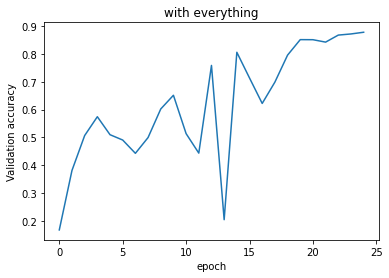

0.87719744


In [8]:
import matplotlib.pyplot as plt
print_training_details(logging_columns_list, column_heads_only=True) ## print out the training column heads before we print the actual content for each run.
num_runs=1
acc_list = []
for run_num in range(num_runs):
    acc_list.append(torch.tensor(main()))


x=np.array(range(25))
for i in range(num_runs):
  plt.plot(x,acc_list[i].detach().numpy())
plt.ylabel("Validation accuracy")
plt.xlabel("epoch")
plt.title("with everything")
plt.show()
print(np.mean([acc_list[i][-1] for i in range(num_runs)]))

In [9]:
#without whitening
class SpeedyResNet(nn.Module):
    def __init__(self, network_dict):
        super().__init__()
        self.net_dict = network_dict # flexible, defined in the make_net function

    # This allows you to customize/change the execution order of the network as needed.
    def forward(self, x):
        if not self.training:
            x = torch.cat((x, torch.flip(x, (-1,))))

        x = self.net_dict['initial_block']['conv'](x)
        x = self.net_dict['initial_block']['norm'](x)
        x = self.net_dict['initial_block']['activation'](x)
        x = self.net_dict['residual1'](x)
        x = self.net_dict['residual2'](x)
        x = self.net_dict['residual3'](x)
        x = self.net_dict['pooling'](x)
        x = self.net_dict['linear'](x)
        x = self.net_dict['temperature'](x)
        if not self.training:
            # Average the predictions from the lr-flipped inputs during eval
            orig, flipped = x.split(x.shape[0]//2, dim=0)
            x = .5 * orig + .5 * flipped
        return x

def make_net():
    # TODO: A way to make this cleaner??
    # Note, you have to specify any arguments overlapping with defaults (i.e. everything but in/out depths) as kwargs so that they are properly overridden (TODO cleanup somehow?)
    whiten_conv_depth = 3*hyp['net']['whitening']['kernel_size']**2
    network_dict = nn.ModuleDict({
        'initial_block': nn.ModuleDict({
            'conv': Conv(in_channels=3, out_channels=depths['init'], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 
            'norm': BatchNorm(depths['init'], weight=False),
            'activation':  nn.GELU(),
        }),
        'residual1': ConvGroup(depths['init'],   depths['block1'], pool=True),
        'residual2': ConvGroup(depths['block1'], depths['block2'], pool=True),
        'residual3': ConvGroup(depths['block2'], depths['block3'], pool=True),
        'pooling': FastGlobalMaxPooling(),
        'linear': nn.Linear(depths['block3'], depths['num_classes'], bias=False),
        'temperature': TemperatureScaler(hyp['opt']['scaling_factor'])
    })

    net = SpeedyResNet(network_dict)
    net = net.to(hyp['misc']['device'])
    net = net.to(memory_format=torch.channels_last) # to appropriately use tensor cores/avoid thrash while training
    net.train()
    net.half() # Convert network to half before initializing the initial whitening layer.

    return net

--------------------------------------------------------------------------------------------------------
|  epoch  |  train_loss  |  val_loss  |  train_acc  |  val_acc  |  ema_val_acc  |  total_time_seconds  |
--------------------------------------------------------------------------------------------------------
|      0  |      2.3047  |    4.3683  |     0.1055  |   0.1386  |               |              1.5530  |
|      1  |      2.2305  |    2.2083  |     0.2627  |   0.3203  |               |              3.0435  |
|      2  |      2.0117  |    2.5242  |     0.3496  |   0.2454  |               |              4.5326  |
|      3  |      2.0117  |    3.3324  |     0.3857  |   0.2102  |               |              6.0270  |
|      4  |      1.9170  |    1.8164  |     0.4180  |   0.4912  |               |              7.5343  |
|      5  |      1.7646  |    1.8459  |     0.5244  |   0.4815  |               |              9.0441  |
|      6  |      1.6982  |    2.1312  |     0.5449  |  

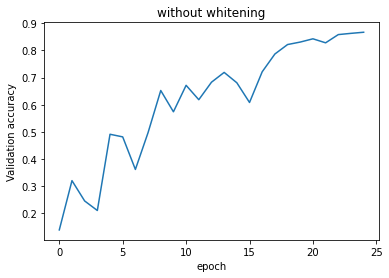

0.8672611


In [17]:
import matplotlib.pyplot as plt
print_training_details(logging_columns_list, column_heads_only=True) ## print out the training column heads before we print the actual content for each run.
num_runs=1
acc_list = []
for run_num in range(num_runs):
    acc_list.append(torch.tensor(main()))


x=np.array(range(25))
for i in range(num_runs):
  plt.plot(x,acc_list[i].detach().numpy())
plt.ylabel("Validation accuracy")
plt.xlabel("epoch")
plt.title("without whitening")
plt.show()
print(np.mean([acc_list[i][-1] for i in range(num_runs)]))

In [12]:
#without pushing_pool_layer_to_beginning

class ConvGroup(nn.Module):
    def __init__(self, channels_in, channels_out, pool):
        super().__init__()
        self.pool = pool # todo: maybe we can condense this later

        self.channels_in = channels_in
        self.channels_out = channels_out

        self.pool1 = nn.MaxPool2d(2)
        self.conv1 = Conv(channels_in, channels_out)
        self.conv2 = Conv(channels_out, channels_out)
        self.norm1 = BatchNorm(channels_out)
        self.norm2 = BatchNorm(channels_out)
        self.activ = nn.GELU()


    def forward(self, x):
        x = self.conv1(x)

        x = self.norm1(x)
        x = self.activ(x)
        if self.pool:
            x = self.pool1(x)
        residual = x
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.activ(x)
        x = x + residual # haiku

        return x


--------------------------------------------------------------------------------------------------------
|  epoch  |  train_loss  |  val_loss  |  train_acc  |  val_acc  |  ema_val_acc  |  total_time_seconds  |
--------------------------------------------------------------------------------------------------------
|      0  |      2.3203  |    5.3104  |     0.1182  |   0.1108  |               |              1.4015  |
|      1  |      2.3887  |    2.3626  |     0.2256  |   0.2622  |               |              2.7963  |
|      2  |      2.1406  |    1.9820  |     0.3066  |   0.3829  |               |              4.1889  |
|      3  |      2.0020  |    2.1513  |     0.3496  |   0.3243  |               |              5.5820  |
|      4  |      1.9424  |    2.0658  |     0.4229  |   0.3722  |               |              6.9760  |
|      5  |      1.8672  |    1.8506  |     0.4395  |   0.4461  |               |              8.3737  |
|      6  |      1.8096  |    1.6168  |     0.4795  |  

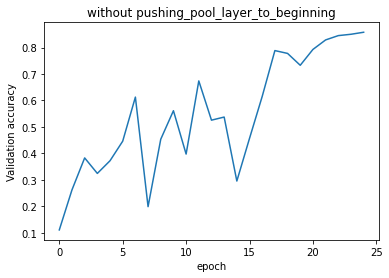

0.85783446


In [14]:
import matplotlib.pyplot as plt
print_training_details(logging_columns_list, column_heads_only=True) ## print out the training column heads before we print the actual content for each run.
num_runs=1
acc_list = []
for run_num in range(num_runs):
    acc_list.append(torch.tensor(main()))


x=np.array(range(25))
for i in range(num_runs):
  plt.plot(x,acc_list[i].detach().numpy())
plt.ylabel("Validation accuracy")
plt.xlabel("epoch")
plt.title("without pushing_pool_layer_to_beginning")
plt.show()
print(np.mean([acc_list[i][-1] for i in range(num_runs)]))

In [15]:
#with ghost batch norm

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits=16, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features*self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features*self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False): #lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
        return super().train(mode)
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.reshape(-1, C*self.num_splits, H, W), self.running_mean, self.running_var, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W) 
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features], 
                self.weight, self.bias, False, self.momentum, self.eps)
            
# can hack any changes to each residual group that you want directly in here
class ConvGroup(nn.Module):
    def __init__(self, channels_in, channels_out, pool):
        super().__init__()
        self.pool = pool # todo: maybe we can condense this later

        self.channels_in = channels_in
        self.channels_out = channels_out

        self.pool1 = nn.MaxPool2d(2)
        self.conv1 = Conv(channels_in, channels_out)
        self.conv2 = Conv(channels_out, channels_out)
        self.norm1 = GhostBatchNorm(channels_out)
        self.norm2 = GhostBatchNorm(channels_out)
        self.activ = nn.GELU()


    def forward(self, x):
        x = self.conv1(x)
        if self.pool:
            x = self.pool1(x)
        x = self.norm1(x)
        x = self.activ(x)
        residual = x
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.activ(x)
        x = x + residual # haiku

        return x


--------------------------------------------------------------------------------------------------------
|  epoch  |  train_loss  |  val_loss  |  train_acc  |  val_acc  |  ema_val_acc  |  total_time_seconds  |
--------------------------------------------------------------------------------------------------------
|      0  |      2.3145  |    2.1661  |     0.0996  |   0.2879  |               |              1.5329  |
|      1  |      2.0820  |    2.3784  |     0.3008  |   0.2680  |               |              3.0316  |
|      2  |      2.0977  |    2.2746  |     0.3271  |   0.2741  |               |              4.5318  |
|      3  |      2.0430  |    3.2664  |     0.3711  |   0.1913  |               |              6.0462  |
|      4  |      1.9180  |    1.8448  |     0.4258  |   0.4810  |               |              7.5565  |
|      5  |      1.7676  |    1.6438  |     0.5195  |   0.5901  |               |              9.0838  |
|      6  |      1.6992  |    2.1064  |     0.5723  |  

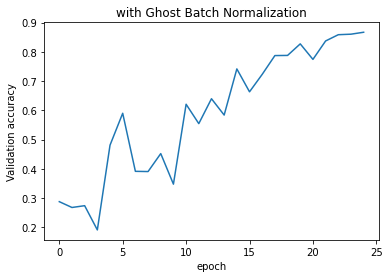

0.8670064


In [16]:
import matplotlib.pyplot as plt
print_training_details(logging_columns_list, column_heads_only=True) ## print out the training column heads before we print the actual content for each run.
num_runs=1
acc_list = []
for run_num in range(num_runs):
    acc_list.append(torch.tensor(main()))


x=np.array(range(25))
for i in range(num_runs):
  plt.plot(x,acc_list[i].detach().numpy())
plt.ylabel("Validation accuracy")
plt.xlabel("epoch")
plt.title("with Ghost Batch Normalization")
plt.show()
print(np.mean([acc_list[i][-1] for i in range(num_runs)]))